In [672]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [673]:
# Import Biopython modules to interact with KEGG
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

import pandas as pd
import numpy as np
from functools import reduce

from src.visualization.plots import HR_GENE_SET, NHEJ_GENE_SET, FANCONI_ANEMIA_GENE_SET
from src.config import get_common_barcodes, HOME_PATH, get_hussmann_supplementary_xlsx, get_experiment_artifacts


MIN_RANKED_DSB_GENE = 3000
T = "isGODSBRepair"

if T == "isGORepair":
    MIN_RANKED_DSB_GENE = 3000
    NUM_PROMISING_GENES = 430
else:
    MIN_RANKED_DSB_GENE = 13000
    NUM_PROMISING_GENES = 408

In [674]:
final_genes = pd.read_csv("../outlier_detection/artifacts/final_gene_list.tsv", sep="\t", usecols=[0, 5, 6], skiprows=1)[1:].rename(columns={"Measure": "Gene"})
final_genes.head()

,Gene,Rank,Pseudo-control
1,Atp6v1g1,1.0,False
2,H2ac18,2.0,False
3,Metap2,3.0,False
4,Xrcc5,4.0,False
5,H2ax,5.0,False


In [675]:
results_f = get_experiment_artifacts() + "/augmented_with_GO_outlier_results.pkl"
full_results_df = pd.read_pickle(results_f)
results_f

'/Users/colm/repos/MUSICian/notebooks/exploratory/outlier_detection/artifacts/paired-replicates.robust_cov.700//augmented_with_GO_outlier_results.pkl'

In [676]:
final_genes = final_genes.set_index("Gene").join(full_results_df[[("Global", T)]].droplevel(axis=1, level=0))

In [677]:
nonGODSBRepair = final_genes[~final_genes[T]]
listA = nonGODSBRepair[:NUM_PROMISING_GENES].index.to_series()
listA.shape

(408,)

In [678]:
GODSBRepair = final_genes[final_genes[T]]
listB = GODSBRepair[GODSBRepair["Rank"] < MIN_RANKED_DSB_GENE].index.to_series()
listB.shape

(254,)

In [679]:
all_hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)
all_hussmann_repair_genes = all_hussmann_repair_genes["Gene"].str.lower().str.capitalize().dropna()
all_hussmann_repair_genes.shape[0]

476

In [680]:
hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)
hussmann_repair_genes = hussmann_repair_genes["Gene.1"].str.lower().str.capitalize().dropna()
most_active_hussmann_genes = np.intersect1d(hussmann_repair_genes, final_genes.index)
missing_hussmann_genes = list(set(hussmann_repair_genes) - set(most_active_hussmann_genes))
most_active_hussmann_genes = final_genes.loc[list(np.intersect1d(final_genes.index, most_active_hussmann_genes))+ ["Wapl", "Sem1", "H2ax", "Abraxas1", "Faap24", "Trp53bp1"]]
most_active_hussmann_genes

,Rank,Pseudo-control,isGODSBRepair
Gene,,,
Aptx,3648.0,False,True
Ascc3,5404.0,False,False
Atm,247.0,False,True
Atr,6777.0,False,True
Atrip,1958.0,False,False
...,...,...,...
Sem1,112.0,False,True
H2ax,5.0,False,True
Abraxas1,1666.0,False,True


In [681]:
print(", ".join(missing_hussmann_genes).upper())

DTL, C19ORF40, FAM175A, WAPAL, SHFM1, SSBP1, TP53BP1, DUT, NHEJ1, H2AFX, FANCE


- Could not find another name for "NHEJ1" that was in our list. See Xlf and cernunnos
- Could not find another name for "FANCE". Also tried Face
----------
- "WAPAL" should be Wapl
- "SHFM1" should be Sem1
- "H2AFX" shuld be H2ax
- "FAM175A" should be Abraxas1
- "C19ORF40" should be Faap24
- "TP53BP1" should be Trp53bp1
----------
- "Dut" sgRNAs were filtered out at the QA stage.
- "Ssbp1" filtered out at QA stage
- "DTL" filtered out at QA stage

In [682]:
listC = np.unique(pd.Series(most_active_hussmann_genes[most_active_hussmann_genes["Rank"] < MIN_RANKED_DSB_GENE].index.to_list() + ["Dut", "Ssbp1", "Dtl"]))
listC.shape

(114,)

In [683]:
from functools import reduce

candidates = reduce(np.union1d, (listA, listB, listC))
candidates.shape

(701,)

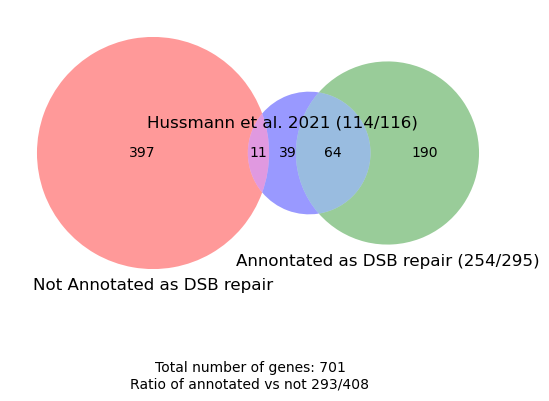

In [684]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

vd = venn3([set(listA), set(listB), set(listC)], ["Not Annotated as DSB repair", "Annontated as DSB repair ({}/{})".format(len(listB), GODSBRepair.shape[0]), "Hussmann et al. 2021 ({}/{})".format(len(listC), most_active_hussmann_genes.shape[0] + 3)])

txt="Total number of genes: {}\nRatio of annotated vs not {}/{}".format(candidates.shape[0], candidates.shape[0]-len(listA), len(listA))
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

lbl = vd.get_label_by_id("C")
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.4))

plt.show()

isGORepair
False         376
True           32
dtype: int64


Text(0.5, 1.0, "Annotated as ''repair'' in GO")

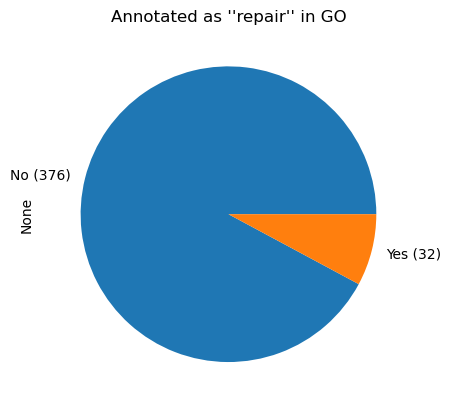

In [685]:

pie_df = full_results_df[[("Global", "isGORepair")]].droplevel(axis=1, level=0).loc[listA].value_counts()
print(pie_df)
pie_df.plot.pie(labels=["No ({})".format(pie_df.iloc[0]), "Yes ({})".format(pie_df.iloc[1])])

plt.title("Annotated as ''repair'' in GO")



Text(0.5, 1.0, 'In Hussmann et al 2021')

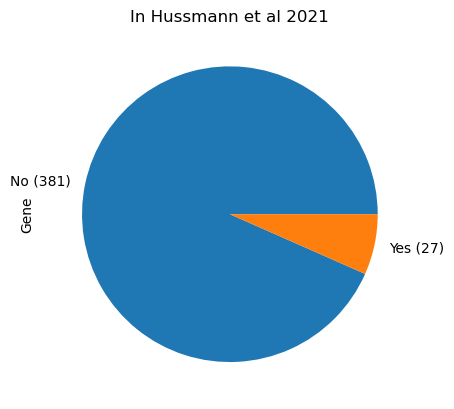

In [686]:
pie_df = full_results_df[[("Global", "isGORepair")]].droplevel(axis=1, level=0).loc[listA].index.to_series().isin(all_hussmann_repair_genes).value_counts()

pie_df.plot.pie(labels=["No ({})".format(pie_df.iloc[0]), "Yes ({})".format(pie_df.iloc[1])])

plt.title("In Hussmann et al 2021")

Text(0.5, 1.0, 'Histogram of ranks of Hussmann gene set')

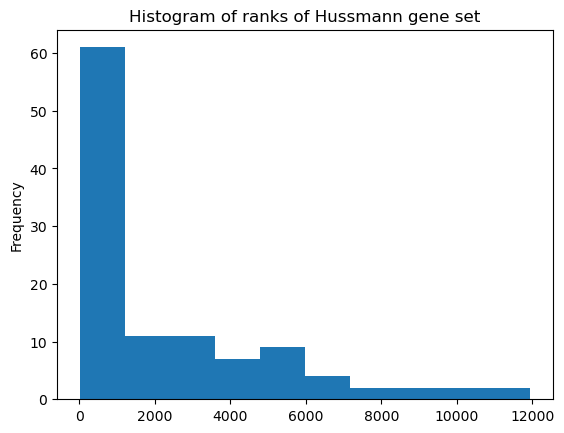

In [695]:
final_genes.loc[np.intersect1d(listC, final_genes.index), "Rank"].plot.hist()
plt.title("Histogram of ranks of Hussmann gene set")

In [ ]:
candidates.shape[0]

701

In [ ]:
np.savetxt("artifacts/candidates.txt", candidates, delimiter=",", fmt='%s')

In [ ]:
from src.visualization.plots import HR_GENE_SET, FANCONI_ANEMIA_GENE_SET, NHEJ_GENE_SET

In [ ]:
def print_details(pathway):
    print("included")
    included_list = list(np.intersect1d(pathway, candidates))
    print(" ".join(included_list))
    print(len(included_list))

    print("excluded")
    excluded_list = list(set(pathway) - set(candidates))
    print(" ".join(excluded_list))
    print(len(excluded_list))

In [ ]:
print_details(HR_GENE_SET)

included
Abraxas1 Atm Babam1 Babam2 Bard1 Blm Brca1 Brca2 Brcc3 Mre11a Nbn Palb2 Pold1 Pold2 Pold3 Rad50 Rad51 Rad51b Rad51c Rad51d Rad52 Rad54b Rad54l Rbbp8 Rpa1 Rpa2 Rpa3 Sem1 Ssbp1 Top3a Topbp1 Uimc1 Xrcc2 Xrcc3
34
excluded
Sycp3 Pold4 Eme1 Mus81 Brip1 Top3b Brcc3dc
7


In [ ]:
print_details(FANCONI_ANEMIA_GENE_SET)

included
Atr Atrip Blm Brca1 Brca2 Cenpx Eme2 Ercc1 Ercc4 Faap100 Faap24 Fan1 Fanca Fancb Fancc Fancd2 Fancf Fancg Fanci Fancl Fancm Mlh1 Palb2 Pms2 Poln Rad51 Rad51c Rev3l Rmi1 Rmi2 Rpa1 Rpa2 Rpa3 Slx1b Slx4 Telo2 Top3a Ube2t Usp1 Wdr48
40
excluded
Polh Cenps Eme1 Mus81 Polk Hes1 Rev1 Brip1 Top3b Poli Fance
11


In [ ]:
print_details(NHEJ_GENE_SET)

included
Dclre1c Dntt Lig4 Mre11a Poll Polm Prkdc Rad50 Xrcc4 Xrcc5 Xrcc6
11
excluded
Fen1 Nhej1
2


In [ ]:
other_potential_genes_of_interest = [
    "Polk",
    "Poli",
    "Polh",
    "Poln",
    "Prkdc",
    "Pold4",
    "Brca2",
    "Rpa1",
]

final_genes.loc[other_potential_genes_of_interest].sort_index()

,Rank,Pseudo-control,isGODSBRepair
Gene,,,
Brca2,4305.0,False,True
Pold4,9029.0,False,False
Polh,3032.0,False,False
Poli,2095.0,False,False
Polk,4691.0,False,False
Poln,5750.0,False,True
Prkdc,1065.0,False,True
Rpa1,2832.0,False,True
